In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import seaborn as sns
sns.set()
my_hm_cm = sns.cubehelix_palette(light=.95, as_cmap=True)
from tqdm.autonotebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.WARNING)

import pystan
import platform
pf = platform.system()
if pf == 'Darwin':
    os.environ["CC"] = "gcc-11"
    # just to be sure
    os.environ["CXX"] = "g++-11"
    os.environ["CXX"] = "g++"
    # os.environ["CXX"] = "clang-10"

import multiprocessing
multiprocessing.set_start_method("fork")

import pickle

<ipython-input-1-7c4c23639eb4>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [50]:
np.__version__

'1.20.2'

In [51]:
pd.__version__

'1.2.4'

In [54]:
import matplotlib
matplotlib.__version__

'3.3.4'

In [56]:
sns.__version__

'0.11.1'

In [55]:
pystan.__version__

'2.19.1.1'

In [2]:
output_path = f'../results/RealData/proposed_model'
os.makedirs(output_path, exist_ok=True)

In [3]:
sf_df = pd.read_csv('../data/stool_freq.tsv', delimiter='\t')

subject_list = sf_df['Subject'].unique().tolist()

y = []
im_df_for_each_subject = []
for subject in subject_list:
    this_subject_frequency_df = sf_df[sf_df['Subject'] == subject]
    y.append(this_subject_frequency_df['Frequency'].cumsum().to_numpy())
    im_df_for_each_subject.append(this_subject_frequency_df['Intake Material'].reset_index()['Intake Material'])

In [4]:
y = np.array(y)

In [10]:
model = pystan.StanModel(file='./model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43e431bc6c6b5de408ee3d41044ad8cb NOW.


In [13]:
mu_max = 5
nu_max = 5
cross_over_type = np.ones(20, dtype=int)
cross_over_type[11:] = 2 
N = 85
# AとBの境界ならBの初めが何日目か
d = [29, 43, 71, 85]
M = 100
t = np.arange(1, N+1)
la_list = []
for i, [yi, Ci] in tqdm(enumerate(zip(y[:], cross_over_type[:])), total=20):
    stan_data = {
                 'N': N, 
                 't': t, 
                 'y': yi, 
                 'mu_max': mu_max, 
                 'nu_max': nu_max, 
                 'd': d, 
                 'cross_over_type': Ci, 
                 'sigma_y_lowerbound': 0.1,
                 }
    fit = model.sampling(data=stan_data, iter=1000, chains=5, n_jobs=5,
                         control={'max_treedepth': 15, 'adapt_delta': 0.80},
                         seed=1)
    la = fit.extract(permuted=True)
    with open(f'{output_path}/la{i}.pkl', 'wb') as g:
        pickle.dump(la, g)
    la_list.append(la)
eta_sample = np.array([la['eta'] for la in la_list])
eta_sample = eta_sample.reshape(20, -1).T

  0%|          | 0/20 [00:00<?, ?it/s]

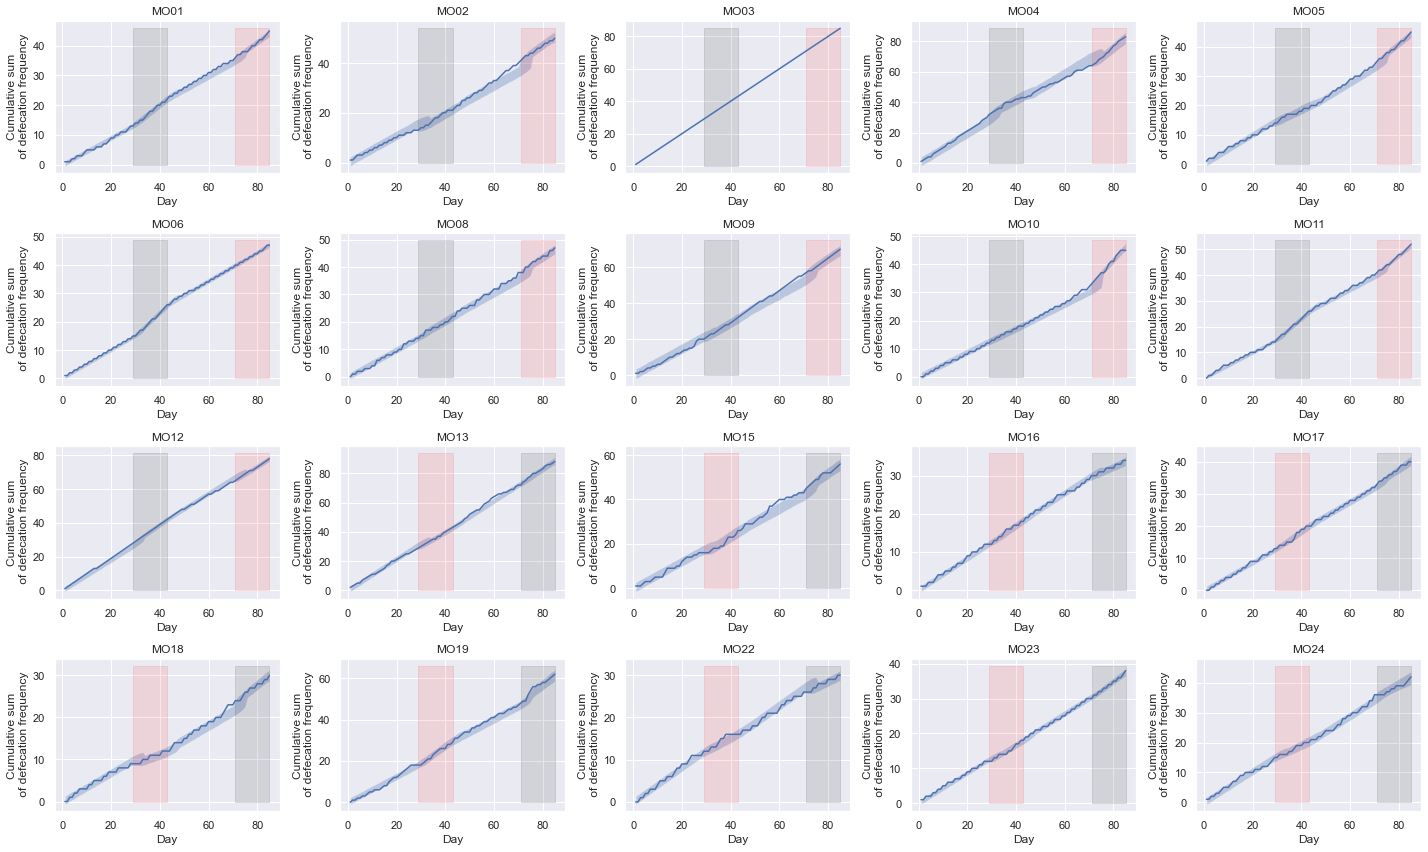

In [18]:
la_df_list = [pd.DataFrame(la['y_pred']) for la in la_list]

fig, axes = plt.subplots(4, 5, figsize=(20, 12))
for i, la_df in enumerate(la_df_list):
    ax = axes[i//5][i%5]
    plt.sca(ax)
    y_srs = pd.Series(y[i], index=range(1, len(y[i])+1))
    y_srs.plot()
    plt.fill_between(y_srs.index, 
                     la_df.quantile(0.025), 
                     la_df.quantile(0.975), alpha=0.3)
    ymax = la_df.max().max()
    color_list = ['black', 'red']
    if cross_over_type[i] == 2:
        color_list = ['red', 'black']
    plt.fill_between([d[0], d[1]], 0, ymax, color=color_list[0], alpha=0.1)
    plt.fill_between([d[2], d[3]], 0, ymax, color=color_list[1], alpha=0.1)
    plt.title(subject_list[i])
    # plt.xticks(t[::10])
    plt.xlabel('Day')
    plt.ylabel('Cumulative sum\n of defecation frequency')
    plt.tight_layout()
plt.show()

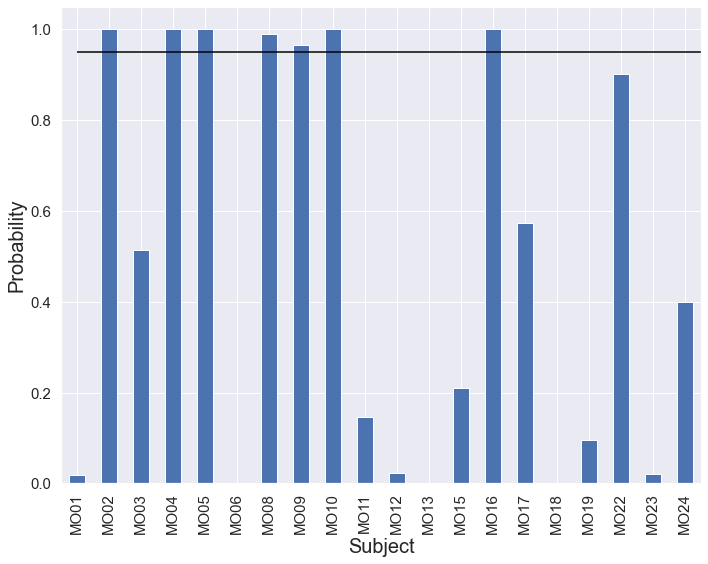

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resp_prob_srs = (pd.DataFrame(eta_sample) > 0).astype(int).mean(0)
resp_prob_srs.index = subject_list
resp_prob_srs.plot.bar(ax=ax)
plt.hlines(y=0.95, xmin=0, xmax=20, colors=['black'])
labelsize = 20
ticksize = 15
ax.set_xlabel('Subject', fontsize=labelsize)
ax.set_ylabel('Probability', fontsize=labelsize)
_ = plt.xticks(fontsize=ticksize)
_ = plt.yticks(fontsize=ticksize)
plt.tight_layout()
plt.show()

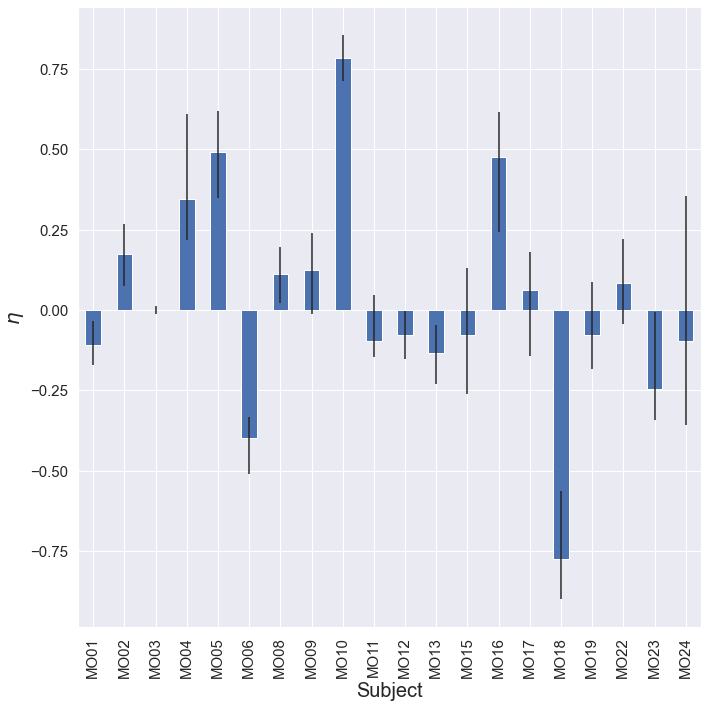

In [22]:
lower_bound = 0.025
upper_bound = 0.975
yerr = np.array([[np.median(eta_sample[:, s]) - pd.Series(eta_sample[:, s]).quantile(lower_bound), 
                  pd.Series(eta_sample[:, s]).quantile(upper_bound) - np.median(eta_sample[:, s])] for s in range(20)]).T
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
eta_est = pd.DataFrame(eta_sample, columns=sf_df['Subject'].unique()).median()
eta_est.plot.bar(yerr=yerr, ax=ax)
labelsize = 20
ticksize = 15
ax.set_xlabel('Subject', fontsize=labelsize)
ax.set_ylabel('$\eta$', fontsize=labelsize)
_ = plt.xticks(fontsize=ticksize)
_ = plt.yticks(fontsize=ticksize)
plt.tight_layout()
plt.show()

In [26]:
np.exp(la['mu_nu_posterior']).mean(0)

array([[4.06155482e-29, 5.94097185e-14, 1.09011878e-03, 4.17408403e-12,
        1.84736281e-02, 3.51924511e-10],
       [1.73386598e-28, 1.35416923e-11, 3.61868863e-02, 3.64198238e-10,
        8.99123412e-01, 5.39489103e-09],
       [8.02858102e-35, 4.47293890e-16, 8.47739517e-06, 1.08639337e-14,
        1.91688349e-04, 1.15429043e-13],
       [1.57567148e-31, 3.90171314e-13, 3.01791898e-03, 1.85661852e-11,
        4.14600718e-02, 5.35023883e-10],
       [6.01485715e-36, 8.71009308e-16, 8.68126785e-06, 4.60467533e-14,
        1.05330002e-04, 9.94364426e-13],
       [1.99241794e-36, 1.68792064e-16, 2.09769058e-05, 1.05525481e-14,
        3.12803907e-04, 6.61686789e-13]])

  0%|          | 0/20 [00:00<?, ?it/s]

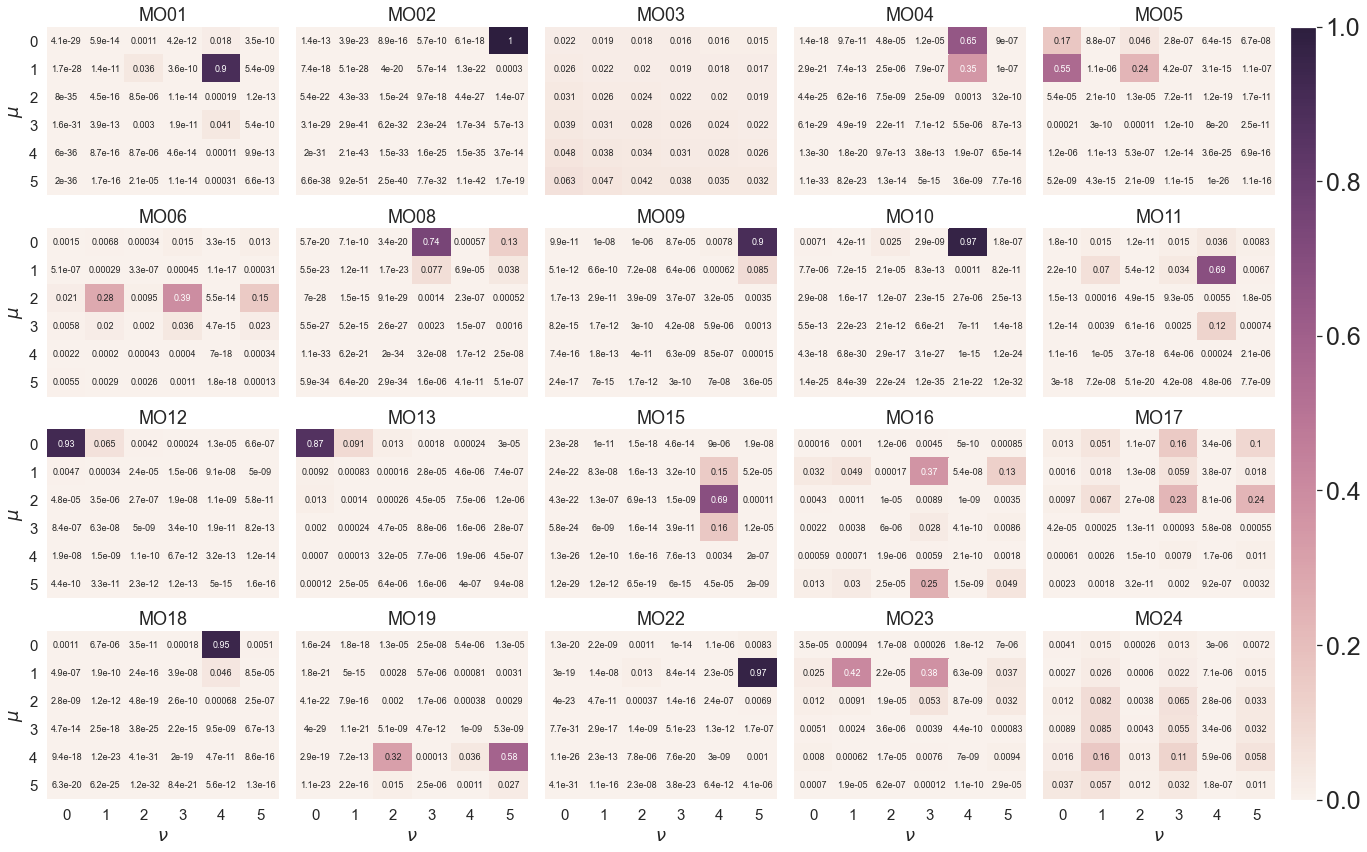

In [30]:
fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(18, 12))
for s, la in tqdm(enumerate(la_list), total=20):

    labelsize = 18
    ticksize = 15
    ax = axes[s//5][s%5]
    sns.heatmap(np.exp(la['mu_nu_posterior']).mean(0), cbar=None, 
                cmap=my_hm_cm, annot=True, annot_kws={"fontsize":9}, ax=ax, vmin=0, vmax=1)
    plt.sca(ax)
    plt.title(subject_list[s], fontsize=labelsize)
    _ = plt.xticks(fontsize=ticksize)
    _ = plt.yticks(fontsize=ticksize, rotation=0)
    if s//5 == 3:
        plt.xlabel('$\\nu$', fontsize=labelsize)
    if s%5 == 0:
        plt.ylabel('$\mu$', fontsize=labelsize, rotation=90)
axpos = ax.get_position()
cbar_ax = fig.add_axes([1, 0.0671, 0.02, 0.895])
norm = colors.Normalize(vmin=0, vmax=1)
mappable = ScalarMappable(cmap=my_hm_cm,norm=norm)
mappable._A = []
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.ax.tick_params(labelsize=25)
plt.tight_layout()
plt.show()

## comparison to the base model

In [31]:
output_path = f'../results/RealData/base_model'
os.makedirs(output_path, exist_ok=True)

In [16]:
model = pystan.StanModel(file='./model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43e431bc6c6b5de408ee3d41044ad8cb NOW.


In [32]:
mu_max = 0
nu_max = 0
cross_over_type = np.ones(20, dtype=int)
cross_over_type[11:] = 2 
N = 85
# AとBの境界ならBの初めが何日目か
d = [29, 43, 71, 85]
t = np.arange(1, N+1)
la_list = []
for i, [yi, Ci] in tqdm(enumerate(zip(y[:], cross_over_type[:])), total=20):
    stan_data = {
                 'N': N, 
                 't': t, 
                 'y': yi, 
                 'mu_max': mu_max, 
                 'nu_max': nu_max, 
                 'd': d, 
                 'cross_over_type': Ci, 
                 'sigma_y_lowerbound': 0.1,
                 }
    fit = model.sampling(data=stan_data, iter=1000, chains=5, n_jobs=5,
                         control={'max_treedepth': 15, 'adapt_delta': 0.80},
                         seed=1)
    la = fit.extract(permuted=True)
    with open(f'{output_path}/la{i}.pkl', 'wb') as g:
        pickle.dump(la, g)
    la_list.append(la)
eta_sample = np.array([la['eta'] for la in la_list])
eta_sample = eta_sample.reshape(20, -1).T

  0%|          | 0/20 [00:00<?, ?it/s]

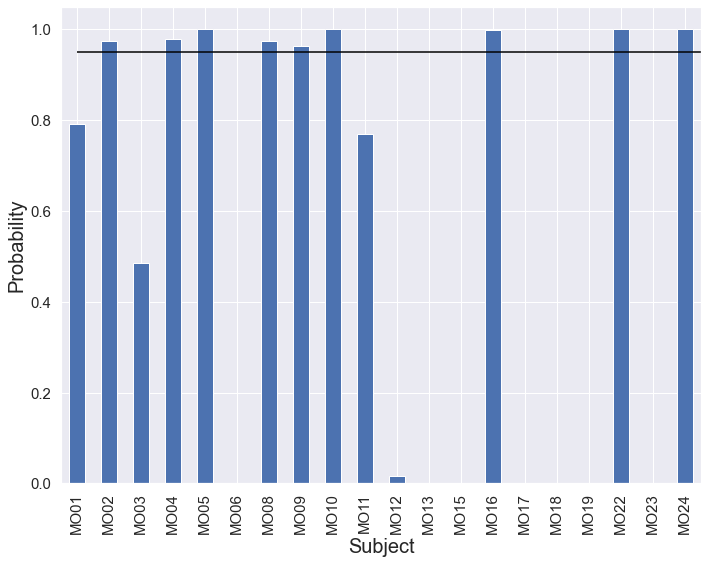

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resp_prob_srs = (pd.DataFrame(eta_sample) > 0).astype(int).mean(0)
resp_prob_srs.index = eta_est.index.tolist()
resp_prob_srs.plot.bar(ax=ax)
plt.hlines(y=0.95, xmin=0, xmax=20, colors=['black'])
labelsize = 20
ticksize = 15
ax.set_xlabel('Subject', fontsize=labelsize)
ax.set_ylabel('Probability', fontsize=labelsize)
_ = plt.xticks(fontsize=ticksize)
_ = plt.yticks(fontsize=ticksize)
plt.tight_layout()
plt.show()

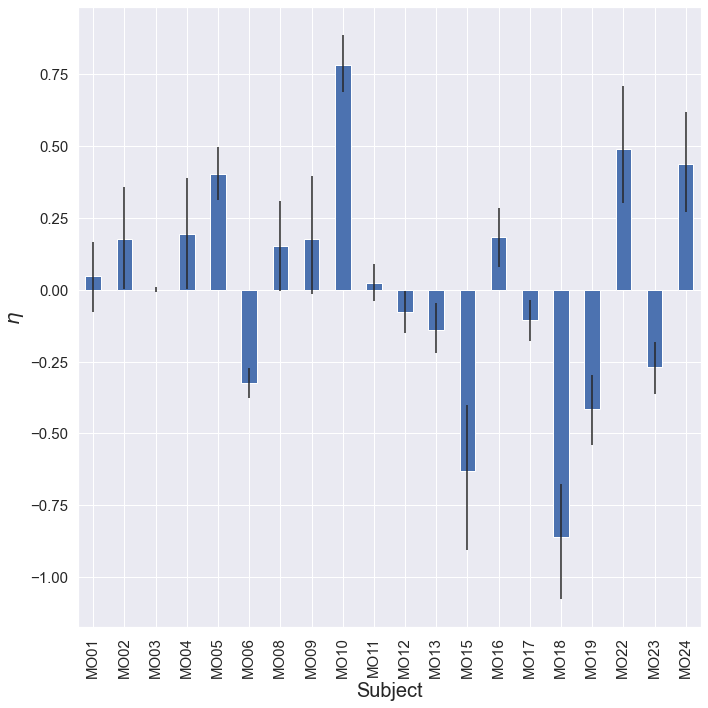

In [35]:
lower_bound = 0.025
upper_bound = 0.975
yerr = np.array([[np.median(eta_sample[:, s]) - pd.Series(eta_sample[:, s]).quantile(lower_bound), 
                  pd.Series(eta_sample[:, s]).quantile(upper_bound) - np.median(eta_sample[:, s])] for s in range(20)]).T
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
eta_est = pd.DataFrame(eta_sample, columns=sf_df['Subject'].unique()).median()
eta_est.plot.bar(yerr=yerr, ax=ax)
labelsize = 20
ticksize = 15
ax.set_xlabel('Subject', fontsize=labelsize)
ax.set_ylabel('$\eta$', fontsize=labelsize)
_ = plt.xticks(fontsize=ticksize)
_ = plt.yticks(fontsize=ticksize)
plt.tight_layout()
plt.show()

In [36]:
def label_day_type(_df, day_type, d1, d2):
    df = _df.copy()
    start_day = df.loc[df['Intake Material']==day_type, 'Day'].min() + d1
    end_day = df.loc[df['Intake Material']==day_type, 'Day'].max() + d2
    df.loc[(df['Day']>=start_day) & (df['Day']<=end_day), 'day_type'] = day_type
    return df['day_type']
def stool_freq_score(sf_df, d1, d2):
    freq_means = []
    subject_list = sf_df['Subject'].unique()
    for subject in subject_list:
        this_stool_df = sf_df[sf_df['Subject']==subject].copy()
        this_stool_df['day_type'] = 'Normal'
        this_stool_df['day_type'] = label_day_type(this_stool_df, 'Test', d1, d2)
        this_stool_df['day_type'] = label_day_type(this_stool_df, 'Placebo', d1, d2)
        freq_mean_srs = this_stool_df.groupby('day_type').mean()['Frequency']
        freq_means.append(freq_mean_srs)
    freq_mean_df = pd.concat(freq_means, axis=1)
    freq_mean_df.columns = subject_list
    freq_mean_df = freq_mean_df.T
    score_srs = np.log(freq_mean_df['Test'] / freq_mean_df['Placebo'])
    return score_srs

In [37]:
score_list_list_list = []
for s, subject_name in enumerate(sf_df['Subject'].unique()):
    score_list_list = []
    for mu in range(6):
        score_list = []
        for nu in range(6):
            score_list.append(stool_freq_score(sf_df, mu, nu)[subject_name])
        score_list_list.append(score_list)
    score_list_list_list.append(score_list_list)

In [38]:
proposed = [
            '○', '●', '○', '●', '●', 
            '○', '●', '●', '●', '○', 
            '○', '○', '○', '●', '○', 
            '○', '○', '○', '○', '○', 
           ]
base = [
        '○', '●', '○', '●', '●', 
        '○', '●', '●', '●', '○', 
        '○', '○', '○', '●', '○', 
        '○', '○', '●', '○', '●', 
       ]

  0%|          | 0/20 [00:00<?, ?it/s]

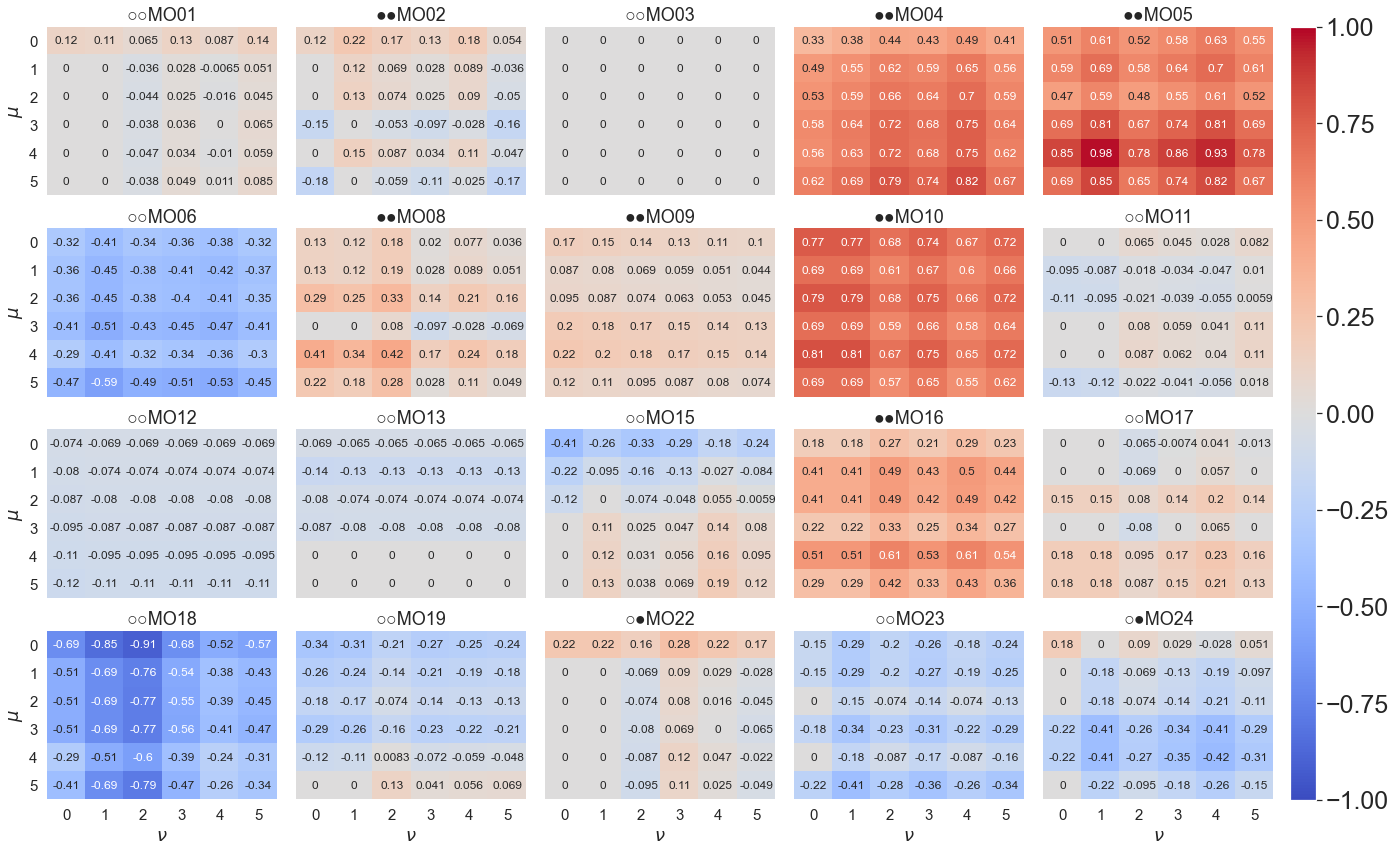

In [41]:
fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(18, 12))
for s, subject_name in tqdm(enumerate(sf_df['Subject'].unique()), total=20):

    labelsize = 18
    ticksize = 15
    ax = axes[s//5][s%5]
    sns.heatmap(np.array(score_list_list_list[s]), cmap='coolwarm', annot=True, cbar=None,
                annot_kws={"fontsize":12}, ax=ax, center=0, vmin=-1, vmax=1)
    plt.sca(ax)
    plt.title(proposed[s] + base[s] + subject_name, fontsize=labelsize)
    _ = plt.xticks(fontsize=ticksize)
    _ = plt.yticks(fontsize=ticksize, rotation=0)
    if s//5 == 3:
        plt.xlabel('$\\nu$', fontsize=labelsize)
    if s%5 == 0:
        plt.ylabel('$\mu$', fontsize=labelsize, rotation=90)
axpos = ax.get_position()
cbar_ax = fig.add_axes([1, 0.0671, 0.02, 0.895])
norm = colors.Normalize(vmin=-1, vmax=1)
mappable = ScalarMappable(cmap='coolwarm',norm=norm)
mappable._A = []
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.ax.tick_params(labelsize=25)
plt.tight_layout()
plt.show()

## microbiome regression

In [42]:
genus = pd.read_csv('../data/genus.tsv', delimiter='\t', index_col=0)

subject_genus_srs_list = []
for subject in subject_list:
    subject_genus_srs_list.append(genus[[f'{subject}_T1']].mean(1))
#     subject_genus_srs_list.append(genus[[f'{subject}_P1',f'{subject}_P2',f'{subject}_P3',
#                                   f'{subject}_T1',f'{subject}_T2',f'{subject}_T3']].mean(1))
subject_genus_df = pd.concat(subject_genus_srs_list, axis=1)
subject_genus_df.columns = subject_list
subject_genus_df = subject_genus_df.T
sg_std_df = subject_genus_df.apply(lambda x: (x-x.mean())/x.std(), axis=0)
sg_std_df = sg_std_df.loc[:, ~(sg_std_df.isnull().any())]

In [43]:
resp_prob_srs.name = 'Responder probability'

In [44]:
# only bacteria that appear in at least <20 - non_zero_threshold> subjects
non_zero_threshold = 5
bacterium_list = subject_genus_df.columns[(subject_genus_df == 0.0).astype(int).sum() <= non_zero_threshold].tolist()

In [45]:
X_df = sg_std_df[bacterium_list]

In [46]:
beta_rgr = pystan.StanModel(file='./beta_rgr.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b21c0d5d5c16a523cf6abf23f8947fb NOW.


In [47]:
lasso_y = resp_prob_srs.copy()
lasso_y[lasso_y==0] = 1e-5
lasso_y[lasso_y==1] = 1 - 1e-5

In [48]:
N = len(X_df.index)
D = len(X_df.columns)
stan_data = {
             'N': N, 
             'D': D, 
             'y': lasso_y, 
             'x': X_df, 
             }

# la = beta_lasso.optimizing(data=stan_data, 
#                           )
                           #init=init_dic)
                           # init='0')

fit = beta_rgr.sampling(data=stan_data, iter=1000, chains=5, n_jobs=5,
                        control={'max_treedepth': 15, 'adapt_delta': 0.80},
                        seed=1)
la = fit.extract(permuted=True)

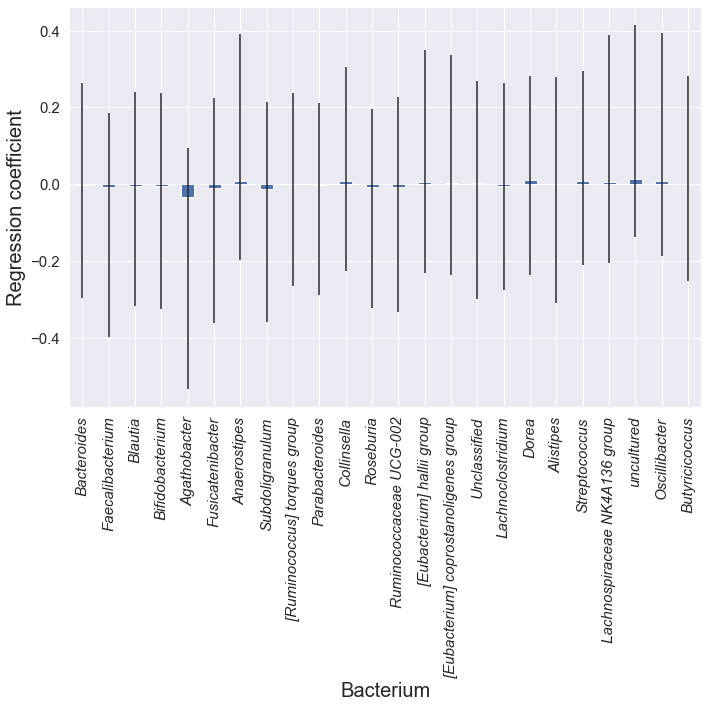

In [49]:
beta_df = pd.DataFrame(la['beta'], columns=X_df.columns)

lower_bound = 0.025
upper_bound = 0.975
yerr = beta_df.apply(lambda x: [x.median()-x.quantile(lower_bound), x.quantile(upper_bound)-x.median()], axis=0).T.to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
beta_df.median().plot.bar(yerr=yerr.T, ax=ax)
labelsize = 20
ticksize = 15
ax.set_xlabel('Bacterium', fontsize=labelsize)
ax.set_ylabel('Regression coefficient', fontsize=labelsize)
_ = plt.xticks(style='italic', fontsize=ticksize)
_ = plt.yticks(fontsize=ticksize)
plt.tight_layout()
plt.show()